In [ ]:
# prompt: mount drive


from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


In [ ]:
import pandas as pd

urls = pd.read_csv('/content/drive/MyDrive/Phishing_URL_detection/merged_urls_mobile_filtered.csv')
urls.shape

(10030, 2)

In [ ]:
# prompt: export urls as merged_urls_mobile_filtered_new

urls.to_csv('/content/drive/MyDrive/Phishing_URL_detection/merged_urls_mobile_filtered_new.csv', index=False)


In [ ]:
# prompt: write a code take 1000 phishing and 1000 benign website from dataset column status

phishing_urls = urls[urls['status'] == 'phishing'].head(1000)
benign_urls = urls[urls['status'] == 'benign'].head(1000)

combined_urls = pd.concat([phishing_urls, benign_urls])


In [ ]:
# prompt: number of rows in url with status as phishing
phishing_urls = urls[urls['status'] == 'phishing']
num_phishing_urls = len(phishing_urls)
print(f"Number of phishing URLs: {num_phishing_urls}")


Number of phishing URLs: 5015


In [ ]:
# prompt: keep the first 20k entries in uls df

urls = urls.head(1000)
len(urls)

1000

In [ ]:
!pip install tldextract python-whois


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 8.0 MB/s eta 0:00:00


In [ ]:
#@title domain name extraction functions

from urllib.parse import urlparse
import tldextract

def extract_domain_name(url):
    domain = tldextract.extract(url)
    return domain.domain

def extract_domain(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    return domain

In [ ]:
def check_bad_form(form, url):
  """
  Checks if a form element has characteristics of a bad form.

  Args:
      form (bs4.element.Tag): The form element to check.

  Returns:
      bool: True if the form has bad characteristics, False otherwise.
  """

  # (1) Check for <input> tags
  if not form.find_all('input'):
    return False

  # (2) Check for keywords or only images
  has_keywords = any(
      keyword in str(form.text.lower()) for keyword in ['password', 'credit card']
  )
  has_images_only = not has_keywords and all(img.name == 'img' for img in form.find_all('img'))

  # (3) Check for action URL and scheme (https or not)
  action_url = form.get('action', '')
  if not action_url:
    action_url = url  # Empty action means same URL

  try:
    response = requests.head(action_url)
    scheme = response.headers.get('scheme', 'http')
  except requests.exceptions.RequestException:
    # Assume non-https if request fails
    scheme = 'http'

  return has_keywords or has_images_only and scheme.lower() != 'https'

In [ ]:
#@title all features to be extracted from the url
import requests
from bs4 import BeautifulSoup
import tldextract
import whois
import re
import threading

"""
features in testing:
1. depth of dom tree
2.

the features are:

Domain features:
1. length of the domain name
2. domain name in copyright logo
3. number of times domain name appears in the url source
4. URL protocol
5. number of non-alphabetical characters in the domain name
6. title of the page contains the domain name
7. link ratio in the body

URL features:
1. length of the URL
2. URL shortening serviec
3. having @ symbol
4. having sub domain
5. contains port

HTML features:
1. presence of favicons
2. presence of forms
3. number of redirections per page
4. presence of alerts
5. number of characters in the html content
6. number of images
7. number of links per page
8. number of iframes per page

Mobile features:
1. number of api calls to tel
2. number of api calls to sms
3. number of api calls to smsto
4. number of api calls to mms
5. number of api calls to mmsto
6. All the numbers found on the page

Experimental features:


"""
def all_features_extraction(url,status):

    try:
        headers = {'User-Agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 15_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Mobile/15E148 Safari/604.1'}
        response = requests.get(url, headers=headers, timeout=5)
        if response.status_code!=200:
            return
        html_content = response.text
        soup = BeautifulSoup(response.content, 'html.parser')
        domain_name = extract_domain_name(url)
        domain = extract_domain(url)
    except:
        print("error in fetching res")
        return



# domain features

# 1. length of domain name
    try:
        domain_length = len(domain)
    except:
        domain_length = None

# # 2. domain name in copyright logo
#     try:
#         domain_name_in_cr_logo = False # to be implemented
#     except:
#         domain_name_in_cr_logo = False

# 3. number of times domain name appears in the url source
    try:
        domain_appearances = soup.text.lower().count(domain_name.lower())
    except:
        domain_appearances = 0

# 4. URL protocol
    try:
        if url.startswith("https://"):
            protocol = True
        else:
            protocol = False
    except:
        protocol = False

# 5. no. of non-alphabetical characters in domain name
    try:
        non_alphabetic_chars = sum(1 for char in domain_name if not char.isalpha())
    except:
        non_alphabetic_chars = 0

# 6. title contains domain name
    try:
        title_contains_domain = domain_name.lower() in soup.title.text.lower()
    except:
        title_contains_domain = False

# 7. link ratio in body
    try:
        all_links = soup.find_all('a')

        # Initialize counts for total links and internal links
        total_links = 0
        internal_links = 0

        # Loop through all <a> tags
        for link in all_links:
            href = link.get('href')

            # Check if href exists and if it's a valid URL
            if href:
                total_links += 1
                parsed_url = urlparse(href)
                if parsed_url.netloc == domain:
                    internal_links += 1

        # Calculate the ratio of internal links to total links
        link_ratio = internal_links / total_links if total_links != 0 else 0

    except:
        link_ratio = 0

# URL features

    url_length = 0
    url_shortening_service = 0
    has_at_symbol = False
    has_subdomain = False
    has_port = 0

    try:
        # Parse the URL
        parsed_url = urlparse(url)

        # 1. Length of the URL
        url_length = len(url)

        # # 2. Check if the URL uses a URL shortening service (e.g., bit.ly, t.co)
        # try:
        #     url_shortening_service = bool(parsed_url.netloc.endswith(('bit.ly', 't.co')))  # Add more shortening services if needed
        # except:
        #     pass

        # 3. Check if the URL contains the @ symbol (commonly found in email addresses)
        try:
            has_at_symbol = '@' in url
        except:
            pass

        # # 4. Check if the URL has a subdomain
        # try:
        #     has_subdomain = bool(parsed_url.hostname.count('.') > 1)
        # except:
        #     pass

        # # 5. Check if the URL contains a port
        # try:
        #     has_port = bool(parsed_url.port)
        # except:
        #     pass

    except:
        pass

# HTML features

    has_favicons = False
    has_forms = False
    form_landing = False
    num_redirections = 0
    has_alerts = 0
    num_characters = 0
    num_images = 0
    num_links = 0
    num_iframes = 0

    # 1. Presence of favicons
    try:
        has_favicons = bool(soup.find("link", rel="icon"))
    except:
        pass

    # 2. Presence of forms
    try:
        has_forms = bool(soup.find("form"))
    except:
        pass

    # 3. forms landing url same as domain
    try:
        form = soup.find('form')
        if form:
            landing_url = form.get('action')
            if urlparse(landing_url).netloc == domain:
                form_landing = True
    except:
        pass


    # # 3. Number of redirections per page
    # try:
    #     num_redirections = len(response.history)
    # except:
    #     pass

    # # 4. Presence of alerts
    # try:
    #     has_alerts = bool(soup.find("script", text="alert"))
    # except:
    #     pass

    # 5. Number of characters in the HTML content
    try:
        num_characters = len(html_content)
    except:
        pass

    # 6. Number of images
    try:
        num_images = len(soup.find_all("img"))
    except:
        pass

    # 7. Number of links per page
    try:
        num_links = len(soup.find_all("a"))
    except:
        pass

    # 8. Number of iframes per page
    try:
        num_iframes = len(soup.find_all("iframe"))
    except:
        pass

    # Javascript specific features
    is_javascript_present=0
    is_external_js_present=0
    total_js=0
    internal_js=0
    external_js=0
    try:



      try:
        response = requests.get(url)
        response.raise_for_status()
        html = response.text
      except:
        pass

      ##javacsript present

      html = html_content
      if html:
          soup = BeautifulSoup(html, 'html.parser')
          if len(soup.find_all('script')) > 0:
            is_javascript_present = 1
          else:
            is_javascript_present = 0
      else:
        is_javascript_present = 0


      ##external javascript present
      if html:
          soup = BeautifulSoup(html, 'html.parser')
          if any(script['src'].startswith('http') for script in soup.find_all('script', {'src': True})):
            is_external_js_present = 1
          else:
            is_external_js_present=0
      else:
        is_external_js_present=0

      ##count scripts

      if html:
          soup = BeautifulSoup(html, 'html.parser')
          total_js = len(soup.find_all('script'))
          external_js = len([script for script in soup.find_all('script', {'src': True}) if script['src'].startswith('http')])
          internal_js = total_js - external_js
      else:
        total_js=0
        external_js=0
        internal_js=0
    except:
      pass

# Experimental URL features
    # 1. is_domain_ip
    is_domain_ip = re.match(r"^\d+\.\d+\.\d+\.\d+$", url) is not None

    # 2. num_subdomain_level
    subdomains = re.findall(r"[^\.]+\.", url)[:-1]  # Exclude TLD
    num_subdomain_level = len(subdomains)

    # 3. has_embedded_domain
    has_embedded_domain = bool(re.search(r"\.[a-z0-9\-]+?\.[a-z]{2,}$", url.split("//")[-1]))

    # 4. num_url_tokens
    num_url_tokens = len(re.findall(r"[^\w\-+\.]", url))

    # 5. has_sensitive_word
    sensitive_words = ["secure", "account", "webscr", "login", "ebayisapi", "signin", "banking", "confirm"]
    has_sensitive_word = any(word in url for word in sensitive_words)

    # 6. is_obfuscated_url
    is_obfuscated_url = (
        bool(re.search(r"[0-9a-f]{2}([:\.])", url))  # Hexadecimal IP representation
        or bool(re.search(r"\.{2,}", url.split("//")[-1]))  # Double or more dots in path
    )

    # 7. len_domain
    domain = url.split("//")[1].split("/")[0]
    len_domain = len(domain)

    # 8. len_path
    path = url.split("//")[-1].split("?")[0].split("#")[0]  # Split at first ?, #
    len_path = len(path)

    # 9. len_url
    len_url = len(url)

    # 10. num_url_dots
    num_url_dots = url.count(".")

    # 11. has_suspicious_char_url
    has_suspicious_char_url = any(char in url for char in ["@", "\x13", "-"])

    # 12. has_tld_out_of_position (heuristic, requires validation with a TLD list)
    has_tld_out_of_position = bool(re.search(r"\.[a-z]{2,}$", url.split("//")[0]))  # TLD in hostname

    # 13. len_fqdn
    len_fqdn = len(url.split("//")[1].split("/")[0])  # FQDN

    # 14. len_mld (heuristic, may not be reliable for all cases)
    mld = domain.split(".")[-2:]  # Assuming the last two segments are MLD
    len_mld = len(".".join(mld))

    # 15. num_mld_terms
    num_mld_terms = len(mld)  # Considering the last two segments as MLD terms

    # 1. has bad forms
    has_bad_forms = any(check_bad_form(form, url) for form in soup.find_all('form'))

    # 2. num terms in title
    title = soup.find('title')
    num_terms_in_title = 0 if title is None else len(title.text.strip().split())

    # 3. num input fields
    num_input_fields = len(soup.find_all('input'))

    # 4. num empty link
    empty_link_patterns = ['a href=""', 'a href="#"', '#javascript::void(0)', '#content', '#skip', 'javascript:;', 'javascript::void(0);']
    num_empty_link = sum(1 for link in soup.find_all('a') if any(pattern in str(link) for pattern in empty_link_patterns))

    # 5. max dom depth (recursive helper function)
    def max_depth(element, depth=0):
        """
        Recursive function to find the maximum depth of a DOM tree.
        """
        if not hasattr(element, 'children') or len(list(element.children)) == 0:
            # Base case: if the element has no children, return the current depth
            return depth
        else:
            # Recursive case: find the maximum depth among children
            return max(max_depth(child, depth + 1) for child in element.children)

    max_dom_depth = max_depth(soup)

    # 6. dom node count
    dom_node_count = len(soup.find_all(True))



    res = {
        'url':url,
        # 'domain_length': domain_length,
        # 'domain_name_in_cr_logo':domain_name_in_cr_logo,
        'domain_appearances':domain_appearances,
        # 'protocol':protocol,
        # 'non_alphabetic_chars':non_alphabetic_chars,
        'title_contains_domain':title_contains_domain,
        'link_ratio':link_ratio,
        # 'url_length':url_length,
        # 'url_shortening_service':url_shortening_service,
        'has_at_symbol':has_at_symbol,
        # 'has_subdomain':has_subdomain,
        # 'has_port':has_port,
        # 'has_favicons': has_favicons,
        'has_forms': has_forms,
        'form_landing': form_landing,
        # 'num_redirections':num_redirections,
        # 'has_alerts':has_alerts,
        # 'num_characters':num_characters,
        'num_images':num_images,
        'num_links':num_links,
        'num_iframes':num_iframes,

        # 'is_javascript_present':is_javascript_present,
        # 'is_external_js_present':is_external_js_present,
        # 'total_js':total_js,
        # 'internal_js':internal_js,
        # 'external_js': external_js,
        # 'tel_count': tel_count,
        # 'sms_count': sms_count,
        # 'smsto_count': smsto_count,
        # 'mmsto_count': mmsto_count,
        #'is_domain_ip': is_domain_ip,
        'num_subdomain_level': num_subdomain_level, # imp
        #'has_embedded_domain': has_embedded_domain,
        # 'num_url_tokens': num_url_tokens,
        'has_sensitive_word': has_sensitive_word, # imp
        # 'is_obfuscated_url': is_obfuscated_url, # imp
        # 'len_domain': len_domain,
        # 'len_path': len_path,
        # 'num_url_dots': num_url_dots,
        'has_suspicious_char_url': has_suspicious_char_url, # suspicious feature
        # 'has_tld_out_of_position': has_tld_out_of_position,
        # 'len_fqdn': len_fqdn,
        # 'len_mld': len_mld,
        # 'num_mld_terms': num_mld_terms,
        # 'has_bad_forms': has_bad_forms,
        'num_terms_in_title': num_terms_in_title, # imp
        # 'num_input_fields': num_input_fields,
        # 'num_empty_link': num_empty_link,
        'max_dom_depth': max_dom_depth, # imp
        'dom_node_count': dom_node_count, # imp
        'status': status
    }
    #print(res)
    features.append(res)

SyntaxError: expected 'except' or 'finally' block (<ipython-input-1-f019a479ce8e>, line 128)

In [ ]:
features = []

In [ ]:

from tqdm import tqdm
def extract_features_all():
    jobs = []
    features = []
    for i,row in tqdm(urls.iterrows()):
        url=row['url']
        status=row['status']
        p1 = threading.Thread(target=all_features_extraction,args=(url,status), name='all_features_extraction')
        jobs.append(p1)
        p1.start()

    for job in jobs:
        job.join(timeout=5)

    features_df = pd.DataFrame(features)

In [ ]:
len(urls)

10030

In [ ]:
extract_features_all()

59it [00:04,  9.20it/s]

error in fetching res


70it [00:06,  5.02it/s]

error in fetching res
error in fetching res


76it [00:12,  1.29it/s]

error in fetching res


80it [00:21,  2.02s/it]

error in fetching res


83it [00:23,  1.17s/it]

error in fetching res


125it [00:50,  2.01it/s]

error in fetching res


152it [00:57,  8.31it/s]

error in fetching res


168it [01:01,  2.64it/s]

error in fetching res


173it [01:05,  1.05it/s]

error in fetching res


230it [01:31,  3.49it/s]

error in fetching res


235it [01:35,  1.51it/s]

error in fetching res


273it [01:49,  1.97it/s]

error in fetching res


274it [01:49,  2.23it/s]

error in fetching res


353it [02:24,  1.36it/s]

error in fetching res


375it [02:31,  3.16it/s]

error in fetching res


384it [02:34,  3.31it/s]

error in fetching res


417it [02:51,  2.16it/s]

error in fetching res


437it [02:59,  3.11it/s]

error in fetching res


497it [03:29,  4.06it/s]

error in fetching res


499it [03:30,  4.12it/s]

error in fetching res


546it [03:44,  6.40it/s]

error in fetching res


578it [04:00,  1.78it/s]

error in fetching res


623it [04:17,  3.08it/s]

error in fetching res


645it [04:24,  4.22it/s]

error in fetching res


698it [04:46,  4.36it/s]

error in fetching res


701it [04:47,  4.18it/s]

error in fetching res


730it [04:58,  1.96it/s]

error in fetching res


762it [05:11,  3.52it/s]

error in fetching res


767it [05:13,  2.45it/s]


KeyboardInterrupt: 

In [ ]:
features

[{'url': 'http://ww25.ypdtc.com/?subid1=20240323-0522-5529-8ce6-ea605f1f834e',
  'domain_appearances': 0,
  'title_contains_domain': False,
  'link_ratio': 0,
  'has_at_symbol': False,
  'has_forms': False,
  'form_landing': False,
  'num_images': 0,
  'num_links': 0,
  'num_iframes': 0,
  'num_subdomain_level': 1,
  'has_sensitive_word': False,
  'has_suspicious_char_url': True,
  'num_terms_in_title': 0,
  'max_dom_depth': 4,
  'dom_node_count': 10,
  'status': 'phishing'},
 {'url': 'https://o-trim.co/waJrQz',
  'domain_appearances': 0,
  'title_contains_domain': False,
  'link_ratio': 0,
  'has_at_symbol': False,
  'has_forms': False,
  'form_landing': False,
  'num_images': 0,
  'num_links': 0,
  'num_iframes': 0,
  'num_subdomain_level': 0,
  'has_sensitive_word': False,
  'has_suspicious_char_url': True,
  'num_terms_in_title': 2,
  'max_dom_depth': 9,
  'dom_node_count': 58,
  'status': 'phishing'},
 {'url': 'https://prsildenaflsult.com/',
  'domain_appearances': 0,
  'title_con

In [ ]:
features_df = pd.DataFrame(features)

In [ ]:
features_df

,url,domain_appearances,title_contains_domain,link_ratio,has_at_symbol,has_forms,form_landing,num_images,num_links,num_iframes,num_subdomain_level,has_sensitive_word,has_suspicious_char_url,num_terms_in_title,max_dom_depth,dom_node_count,status
0,http://ww25.ypdtc.com/?subid1=20240323-0522-55...,0,False,0.000000,False,False,False,0,0,0,1,False,True,0,4,10,phishing
1,https://o-trim.co/waJrQz,0,False,0.000000,False,False,False,0,0,0,0,False,True,2,9,58,phishing
2,https://prsildenaflsult.com/,0,False,0.615385,False,False,False,8,39,0,0,False,False,10,11,202,benign
3,https://bayatee.com/,3,True,0.000000,False,True,False,4,17,1,0,False,False,12,18,144,benign
4,https://undress.vip/,2,True,0.000000,False,False,False,0,0,0,0,False,False,7,8,29,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,https://www.stardem.com/,1,True,0.053957,False,True,False,57,291,5,1,False,False,8,22,2065,benign
948,https://www.bitrix24.com/,20,True,0.053061,False,True,False,50,245,0,1,False,False,14,27,1836,benign
949,https://ridebicycles.com/,0,False,0.005038,False,True,False,110,397,0,0,False,False,9,21,4220,benign
950,https://ckbrace.co.kr/,2,False,0.754386,False,True,False,8,63,0,1,False,False,1,19,424,benign


In [ ]:
# prompt: export features_df as csv with name all_features_train

features_df.to_csv('/content/drive/MyDrive/Phishing_URL_detection/features_train_filtered_new_features.csv')


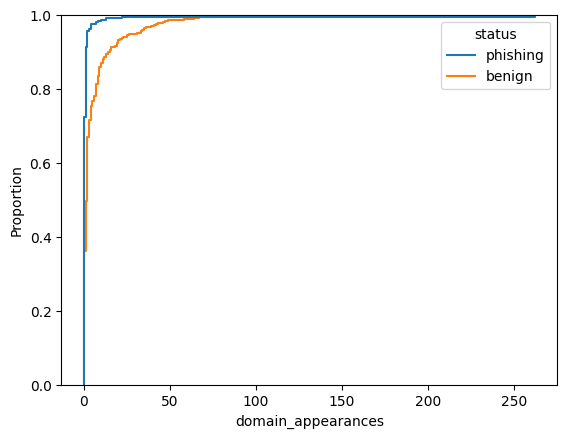

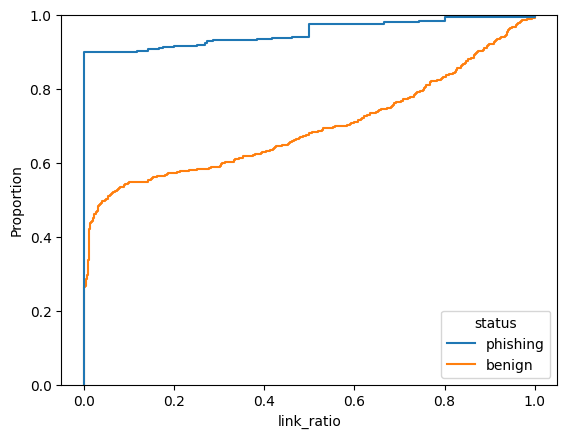

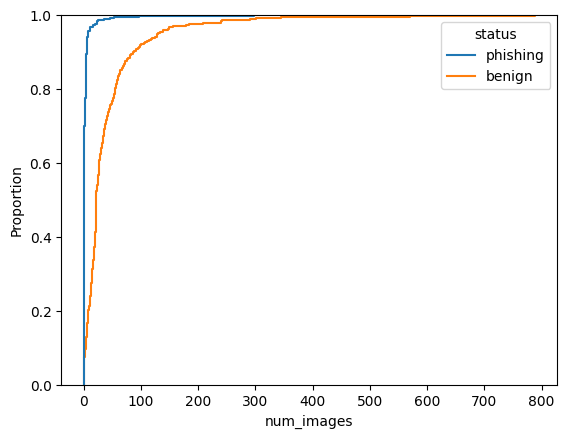

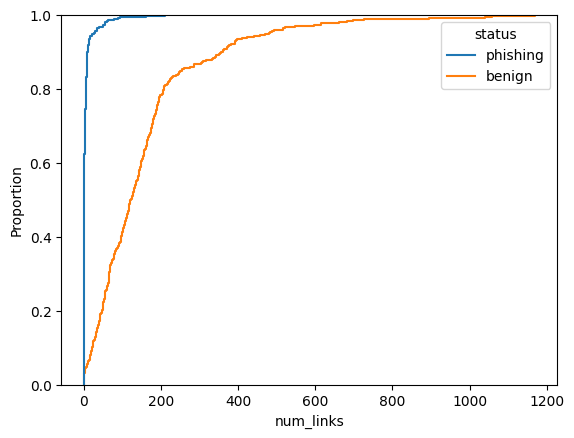

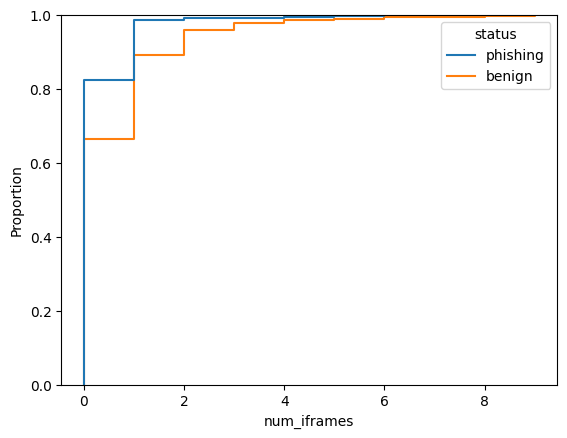

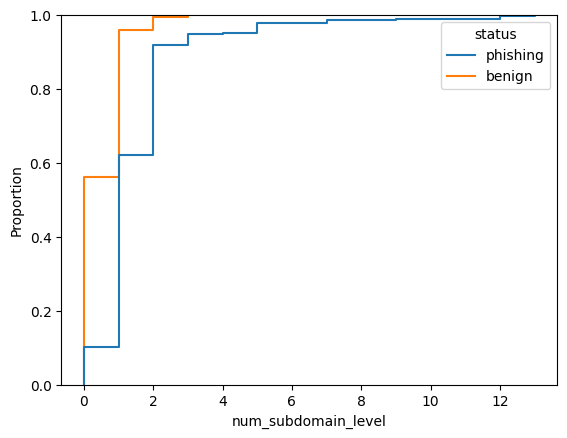

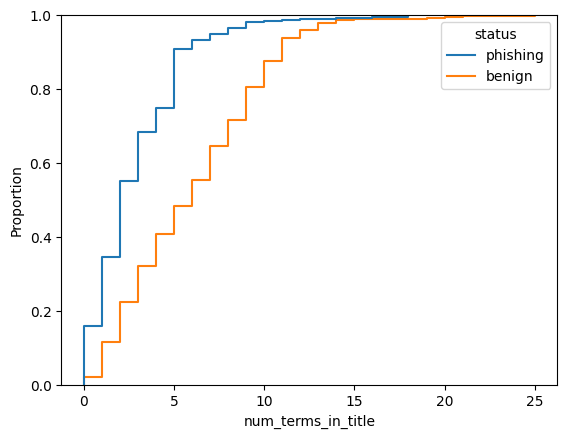

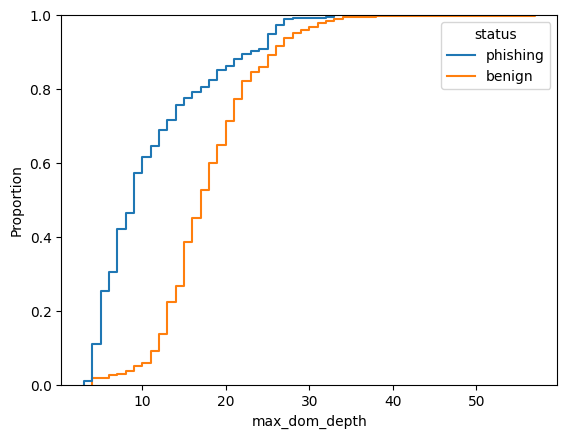

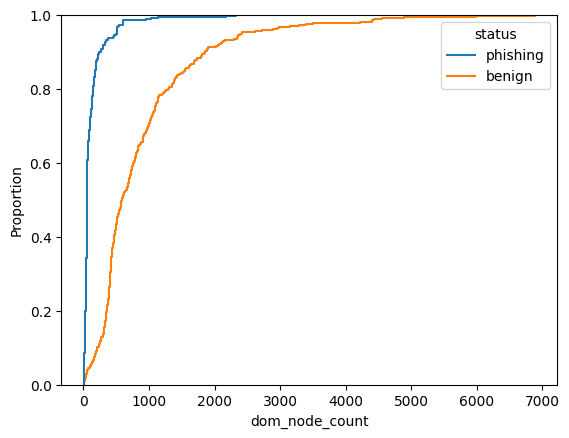

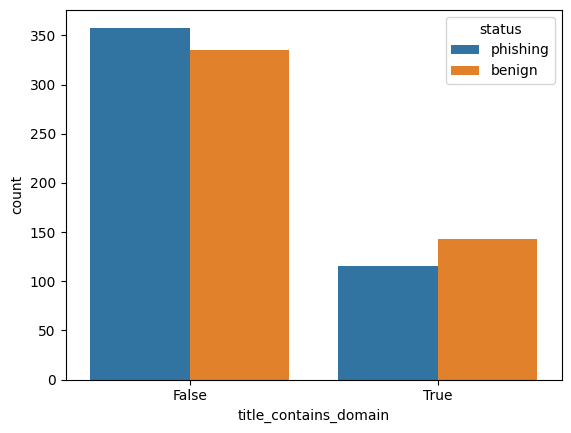

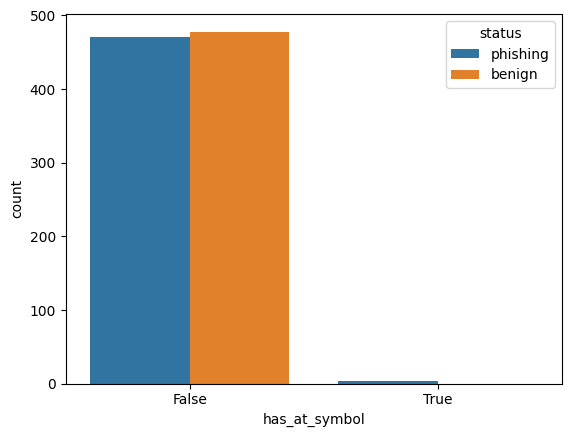

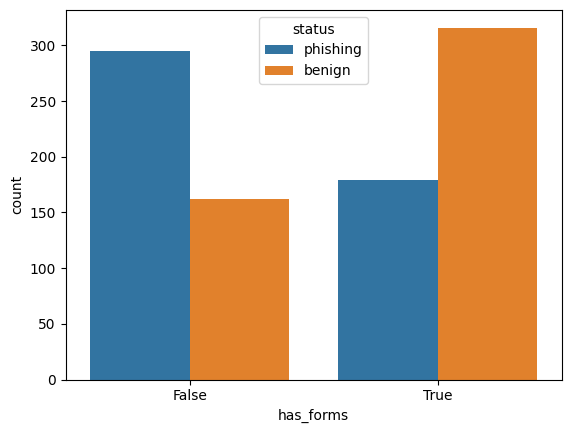

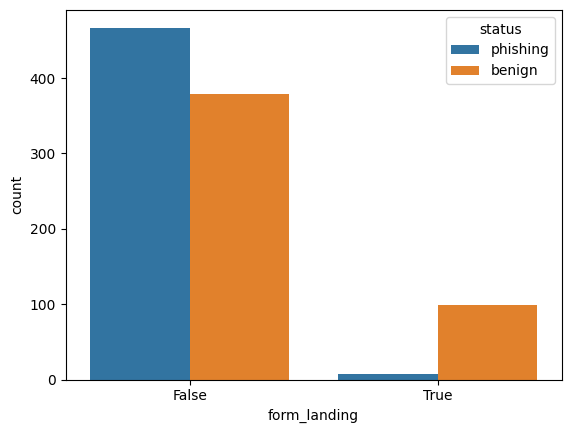

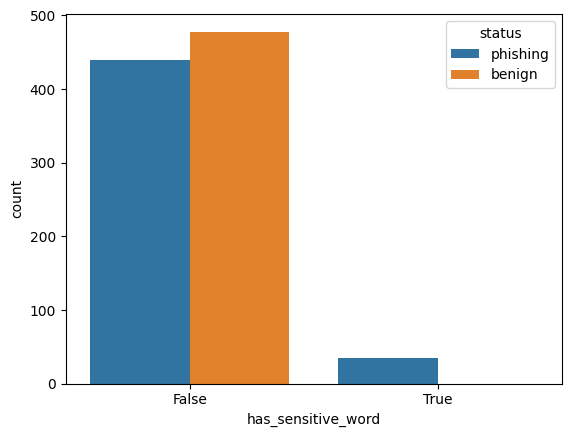

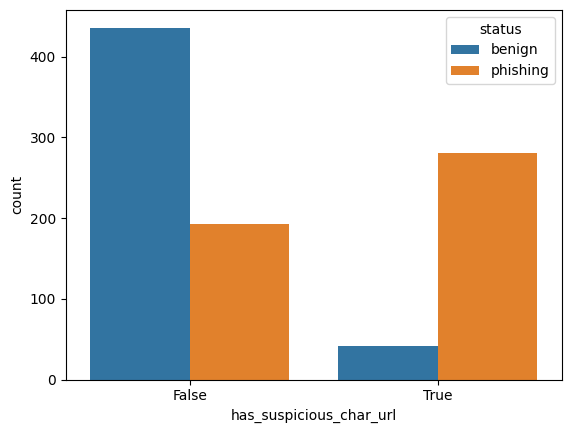

In [ ]:
# prompt: plot ecdf plot for each numerical feature and binary feature distribution for boolean features

import matplotlib.pyplot as plt
import seaborn as sns

# Plot ECDF for each numerical feature
for col in features_df.select_dtypes(include=["int64", "float64"]):
    sns.ecdfplot(data=features_df, x=col, hue='status')
    plt.show()

# Plot binary feature distribution for boolean features
for col in features_df.select_dtypes(include=["bool"]):
    sns.countplot(data=features_df, x=col, hue='status')
    plt.show()


In [ ]:
import numpy as np

# Generate a random integer array
np.random.seed(0)
data = np.random.randint(0, 10, size=100)
print(data)
# Define possible split points (e.g., midpoints between consecutive integers)
possible_split_points = np.arange(0.5, 9.5, 1)
print(possible_split_points)
# Calculate the best split point using Gini index

def find_best_gini_split(possible_split_points,data):
    sorted_indices = np.argsort(data)
    sorted_data = data[sorted_indices]
    sorted_status = status[sorted_indices]

    def calculate_gini_index(split_point, sorted_data, sorted_status):
        # Split the status based on the split point
        left_status = sorted_status[sorted_data <= split_point]
        right_status = sorted_status[sorted_data > split_point]

        # Calculate weights
        total_samples = len(sorted_data)
        left_weight = len(left_status) / total_samples
        right_weight = len(right_status) / total_samples

        # Calculate Gini impurity for left and right subsets
        gini_left = 1 - np.sum(np.square(np.bincount(left_status) / len(left_status)))
        gini_right = 1 - np.sum(np.square(np.bincount(right_status) / len(right_status)))

        # Calculate weighted Gini index
        gini_index = left_weight * gini_left + right_weight * gini_right

        return gini_index

    # Calculate Gini index for all possible split points
    min_gini_index = float('inf')
    min_threshold = None

    for i in range(len(sorted_data) - 1):
        threshold = (sorted_data[i] + sorted_data[i+1]) / 2
        gini_index = calculate_gini_index(threshold, sorted_data, sorted_status)
        if gini_index < min_gini_index:
            min_gini_index = gini_index
            min_threshold = threshold

    return min_threshold

# Calculate the best split point using cross-entropy
def find_best_cross_entropy_split(possible_split_points,data):
    def calculate_cross_entropy(split_point, data):
        left_subset = data[data <= split_point]
        right_subset = data[data > split_point]

        left_prob = len(left_subset) / len(data)
        right_prob = len(right_subset) / len(data)

        classes = np.unique(data)
        left_class_prob = np.array([np.sum(left_subset == c) / len(left_subset) for c in classes])
        right_class_prob = np.array([np.sum(right_subset == c) / len(right_subset) for c in classes])

        left_cross_entropy = -np.sum(left_class_prob * np.log(left_class_prob + 1e-15))
        right_cross_entropy = -np.sum(right_class_prob * np.log(right_class_prob + 1e-15))

        cross_entropy = (left_prob * left_cross_entropy) + (right_prob * right_cross_entropy)

        return cross_entropy

    best_cross_entropy_split = None
    best_cross_entropy = float('inf')
    for split_point in possible_split_points:
        cross_entropy = calculate_cross_entropy(split_point, data)
        if cross_entropy < best_cross_entropy:
            best_cross_entropy = cross_entropy
            best_cross_entropy_split = split_point

    return best_cross_entropy_split

print(find_best_gini_split(possible_split_points, data))
print(find_best_cross_entropy_split(possible_split_points, data))

[5 0 3 3 7 9 3 5 2 4 7 6 8 8 1 6 7 7 8 1 5 9 8 9 4 3 0 3 5 0 2 3 8 1 3 3 3
 7 0 1 9 9 0 4 7 3 2 7 2 0 0 4 5 5 6 8 4 1 4 9 8 1 1 7 9 9 3 6 7 2 0 3 5 9
 4 4 6 4 4 3 4 4 8 4 3 7 5 5 0 1 5 9 3 0 5 0 1 2 4 2]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5]


NameError: name 'status' is not defined